In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test = pd.read_csv("/content/drive/MyDrive/Kaggle/rossmann-store-sales/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Kaggle/rossmann-store-sales/train.csv")
store = pd.read_csv("/content/drive/MyDrive/Kaggle/rossmann-store-sales/store.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/Kaggle/rossmann-store-sales/sample_submission.csv")

<ipython-input-3-65faa389258c>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/Kaggle/rossmann-store-sales/train.csv")


In [12]:
import warnings
warnings.filterwarnings("ignore")

from pandas import datetime
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. 기술통계 및 추정 (7)

 [✔️] 데이터셋의 전체 구조 파악 (변수의 종류, 데이터의 크기 등) \
 [✔️] 기술통계량 계산 (평균, 중앙값, 분산, 표준편차 등) \
 [✔️] 데이터 분포 탐색 (정규성 검정, 왜도 및 첨도 분석) \
 [✔️] 이상치 탐색 및 처리 \
 [✔️] 결측치 탐색 및 처리 \
 [✔️] 상관관계 분석 \
 [✔️] 시각화를 통한 데이터 탐색 (히스토그램, 박스플롯, 산점도 등) \



### 1.1 데이터셋의 전체 구조 파악
- 변수의 종류, 데이터 크기 등

In [ ]:
sample_submission.sample(3)

,Id,Sales
41066,41067,0
25983,25984,0
12794,12795,0


In [ ]:
store.sample(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
754,755,d,c,13130.0,12.0,2003.0,0,NaN,NaN,NaN
856,857,c,a,6270.0,8.0,2005.0,1,23.0,2014.0,"Mar,Jun,Sept,Dec"
737,738,d,c,5980.0,10.0,2005.0,0,NaN,NaN,NaN


In [ ]:
train.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
532559,375,2,2014-03-11,6492,663,1,0,0,0
937812,883,3,2013-03-13,4106,453,1,0,0,0
78472,423,5,2015-05-22,12275,2046,1,1,0,0


In [ ]:
test.sample(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
8036,8037,430,2,2015-09-08,1.0,0,0,1
7078,7079,301,3,2015-09-09,1.0,0,0,0
1975,1976,342,2,2015-09-15,1.0,1,0,0


In [ ]:
test.shape, train.shape, store.shape, sample_submission.shape

((41088, 8), (1017209, 12), (1115, 10), (41088, 2))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

### 1.2 기술통계량 계산
- 평균, 중앙값, 분산, 표준편차 등

In [ ]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
train["StateHoliday"].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
train[train["StateHoliday"] == 0].count()

Store            131072
DayOfWeek        131072
Date             131072
Sales            131072
Customers        131072
Open             131072
Promo            131072
StateHoliday     131072
SchoolHoliday    131072
dtype: int64

In [ ]:
train[train["StateHoliday"] == "0"].count()

Store            855087
DayOfWeek        855087
Date             855087
Sales            855087
Customers        855087
Open             855087
Promo            855087
StateHoliday     855087
SchoolHoliday    855087
dtype: int64

In [ ]:
# 데이터 정리, 정수화
train["StateHoliday"] = train["StateHoliday"].replace({"0" : 0, "a": 1, "b" : 2, "c": 3})
train["StateHoliday"].value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

In [26]:
# Date
train["Day"] = pd.to_datetime(train["Date"]).dt.day

In [27]:
train["Month"] = pd.to_datetime(train["Date"]).dt.month
train["Year"] = pd.to_datetime(train["Date"]).dt.year
train_1 = train.drop(columns=["Date"])

In [29]:
# 'Date' 열을 Datetime 객체로 변환
train['Date'] = pd.to_datetime(train['Date'])

# 'Date' 열에서 주차 정보를 추출하여 새로운 열로 저장
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

In [30]:
train.drop(columns=["Date"], inplace=True)

In [ ]:
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   Store          1017209 non-null  int64
 1   DayOfWeek      1017209 non-null  int64
 2   Sales          1017209 non-null  int64
 3   Customers      1017209 non-null  int64
 4   Open           1017209 non-null  int64
 5   Promo          1017209 non-null  int64
 6   StateHoliday   1017209 non-null  int64
 7   SchoolHoliday  1017209 non-null  int64
 8   Day            1017209 non-null  int64
 9   Month          1017209 non-null  int64
 10  Year           1017209 non-null  int64
dtypes: int64(11)
memory usage: 85.4 MB


In [ ]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [ ]:
store.sample(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
696,697,d,a,3780.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
560,561,d,a,14300.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [ ]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### 1.3 데이터 분포 탐색
- 정규성 검정, 왜도 및 첨도 분석

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 데이터 예시

# Min-Max 정규화
min_max_scaler = MinMaxScaler()
train_norm = min_max_scaler.fit_transform(train_1)
print("Min-Max 정규화 결과:\n", train_norm)

# Z-점수 정규화
standard_scaler = StandardScaler()
train_z = standard_scaler.fit_transform(train_1)
print("Z-점수 정규화 결과:\n", train_z)

Min-Max 정규화 결과:
 [[0.00000000e+00 6.66666667e-01 1.26663618e-01 ... 1.00000000e+00
  5.45454545e-01 1.00000000e+00]
 [8.97666068e-04 6.66666667e-01 1.45941133e-01 ... 1.00000000e+00
  5.45454545e-01 1.00000000e+00]
 [1.79533214e-03 6.66666667e-01 2.00091454e-01 ... 1.00000000e+00
  5.45454545e-01 1.00000000e+00]
 ...
 [9.98204668e-01 1.66666667e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99102334e-01 1.66666667e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.66666667e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Z-점수 정규화 결과:
 [[-1.73164032  0.50148416 -0.13268286 ...  1.74076566  0.3467243
   1.50207687]
 [-1.72853385  0.50148416  0.07537318 ...  1.74076566  0.3467243
   1.50207687]
 [-1.72542738  0.50148416  0.65980026 ...  1.74076566  0.3467243
   1.50207687]
 ...
 [ 1.72275751 -1.00047591 -1.49972273 ... -1.67312281 -1.45719295
  -1.07061593]
 [ 1.72586398 -1.00047591 -1.49972273 ... -

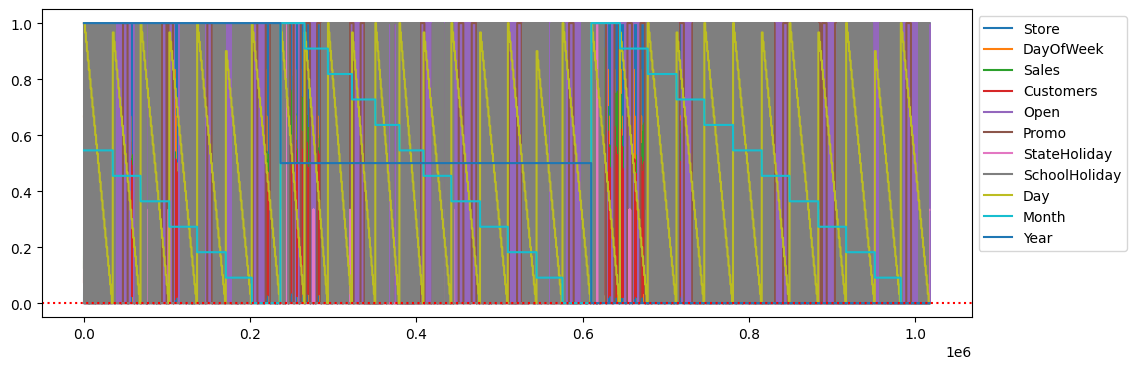

In [ ]:
train_norm = pd.DataFrame(train_norm, columns=train_1.columns)
train_norm.plot(figsize=(12, 4))
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(0, ls=":", c="r")
plt.show()

In [ ]:
train_norm

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,0.000000,0.666667,0.126664,0.075122,1.0,1.0,0.000000,1.0,1.0,0.545455,1.0
1,0.000898,0.666667,0.145941,0.084597,1.0,1.0,0.000000,1.0,1.0,0.545455,1.0
2,0.001795,0.666667,0.200091,0.111126,1.0,1.0,0.000000,1.0,1.0,0.545455,1.0
3,0.002693,0.666667,0.336815,0.202761,1.0,1.0,0.000000,1.0,1.0,0.545455,1.0
4,0.003591,0.666667,0.116050,0.075663,1.0,1.0,0.000000,1.0,1.0,0.545455,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1017204,0.996409,0.166667,0.000000,0.000000,0.0,0.0,0.333333,1.0,0.0,0.000000,0.0
1017205,0.997307,0.166667,0.000000,0.000000,0.0,0.0,0.333333,1.0,0.0,0.000000,0.0
1017206,0.998205,0.166667,0.000000,0.000000,0.0,0.0,0.333333,1.0,0.0,0.000000,0.0
1017207,0.999102,0.166667,0.000000,0.000000,0.0,0.0,0.333333,1.0,0.0,0.000000,0.0


In [ ]:
train_norm.plot(figsize=(12, 4))
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(0, ls=":", c="r")
plt.show()

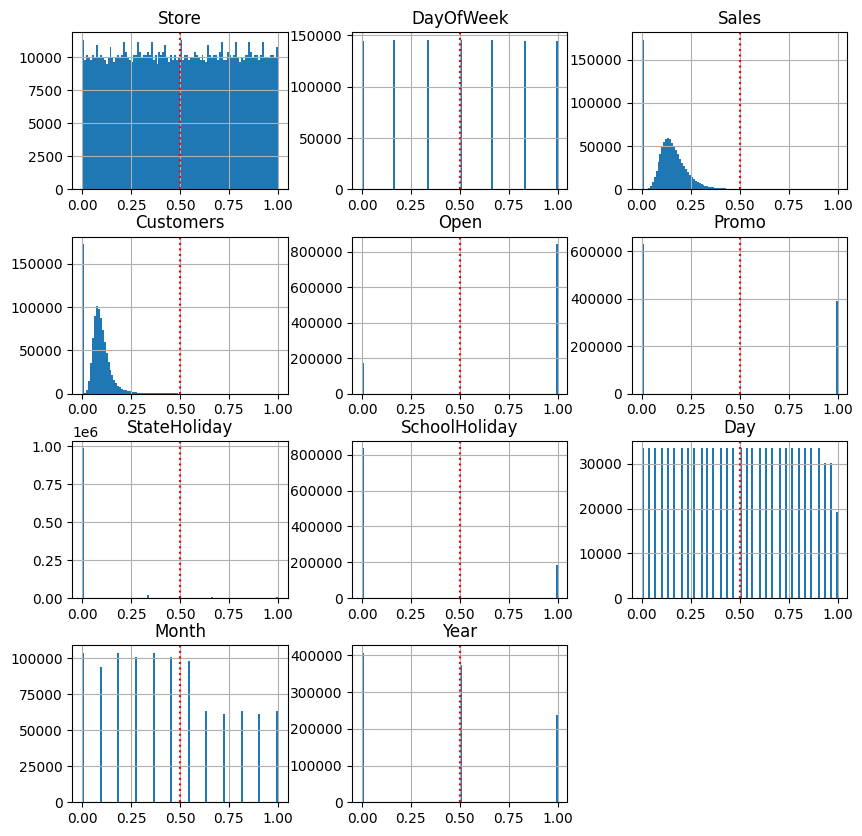

In [ ]:
axes = train_norm.hist(bins=100, figsize=(10, 10));

for ax in axes.flat:
  ax.axvline(0.5, c="r", ls=":")
plt.show()

- 왜도와 첨도

In [ ]:
train_norm.skew() # 왜도

Store           -0.000955
DayOfWeek        0.001593
Sales            0.641460
Customers        1.598650
Open            -1.758045
Promo            0.487838
StateHoliday     7.464614
SchoolHoliday    1.677842
Day              0.008454
Month            0.274202
Year             0.300265
dtype: float64

In [ ]:
train_norm.kurt() # 첨도

Store            -1.200524
DayOfWeek        -1.246873
Sales             1.778375
Customers         7.091773
Open              1.090723
Promo            -1.762018
StateHoliday     61.854897
SchoolHoliday     0.815154
Day              -1.192006
Month            -1.017876
Year             -1.290603
dtype: float64

### 1.4  이상치 탐색 및 처리

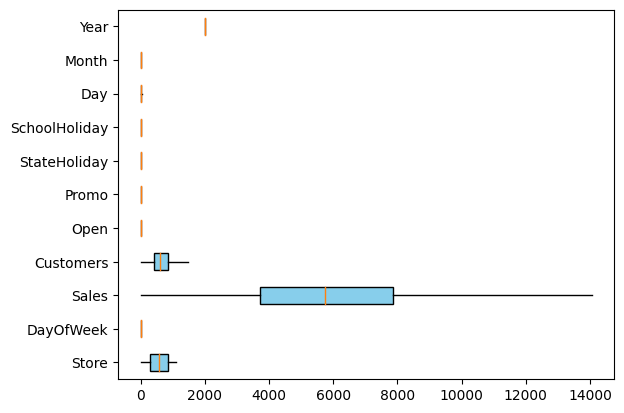

In [ ]:
numeric_cols = train_1.select_dtypes(include='number')

fig, ax = plt.subplots()
ax.boxplot(numeric_cols.values, vert=False, patch_artist=True, labels=numeric_cols.columns,
          showfliers = False, showcaps=False, boxprops = dict(facecolor="skyblue"))
plt.show()

<Axes: xlabel='Sales'>

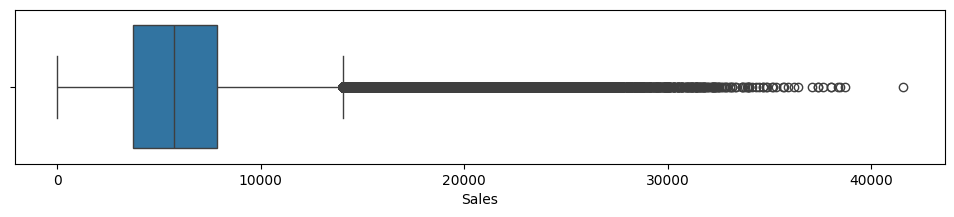

In [ ]:
plt.figure(figsize=(12,2))
sns.boxplot(data=train_1, x="Sales")

### 1.5  결측치 탐색 및 처리

In [ ]:
store.isna().mean()

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [ ]:
store.sample(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
223,224,d,c,7930.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
192,193,a,a,520.0,NaN,NaN,0,NaN,NaN,NaN
345,346,a,c,8090.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
p2_store = store[store["Promo2"] == 1]

In [ ]:
train.isna().mean()

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
Day              0.0
Month            0.0
Year             0.0
dtype: float64

In [6]:
# closed stores
print(train[(train.Open == 0) & (train.Sales == 0)].shape)
train[(train.Open == 0) & (train.Sales == 0)].head()

(172817, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


- 172817곳 폐점 상점.
- 전체 10%, 편향 피하기 위해 삭제 요망

In [8]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total:", zero_sales.shape)
zero_sales.head()

In total: (54, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0


In [14]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [15]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [16]:
# no promo 가 뭐지..
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [17]:
# replace NA's by 0
store.fillna(0, inplace = True)

### 1.6  상관관계 분석



<AxesSubplot:>

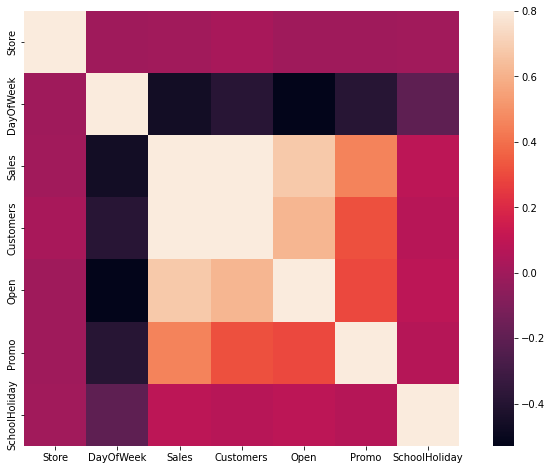

In [ ]:
numeric_cols = train.select_dtypes(include='number')
corrmat = numeric_cols.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corrmat, vmax=0.8, square=True)

- 1.7 후 추가

In [40]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [41]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,5738.179710,659.034880,12882.592255,7122.919204
b,10058.837334,1987.720846,17264.621605,11264.823310
c,5723.629246,673.265894,12128.625157,6737.717159
d,5641.819243,501.434892,10397.346995,9038.541369


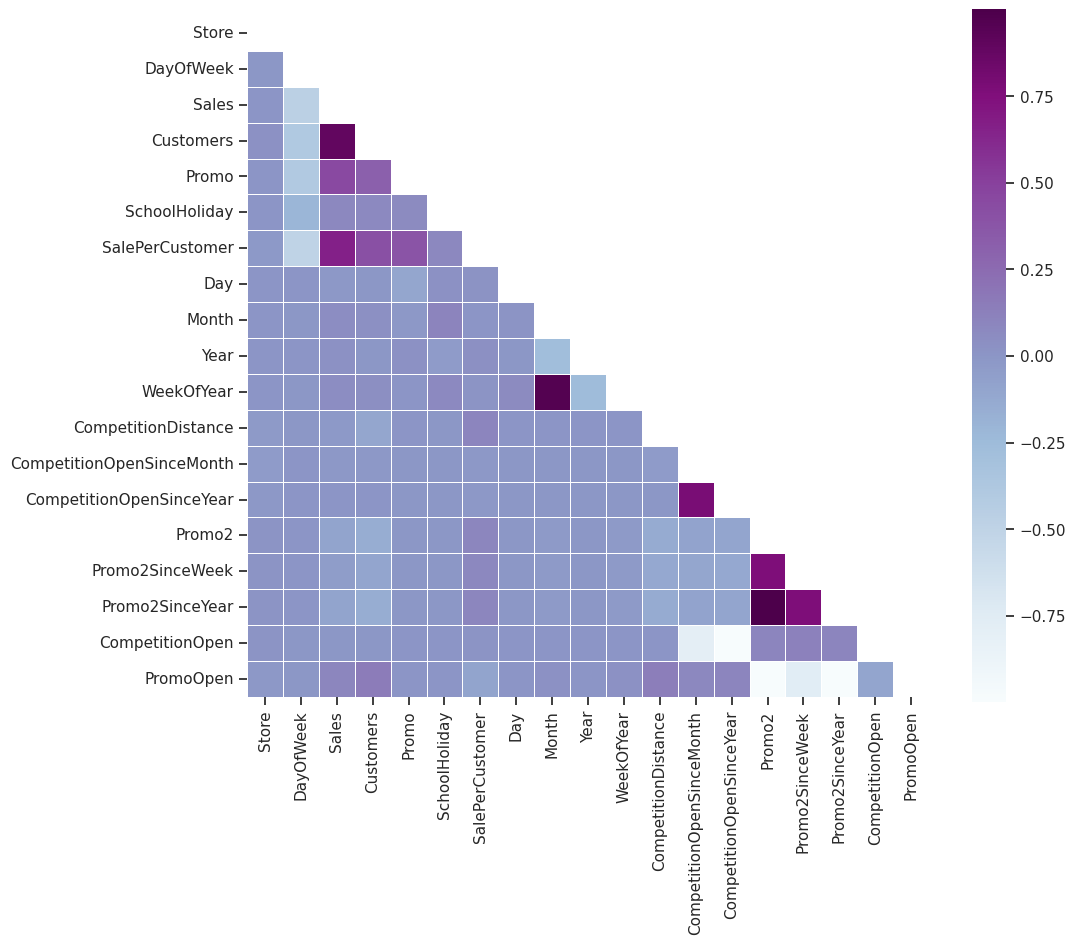

In [42]:
# Compute the correlation matrix
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.show()

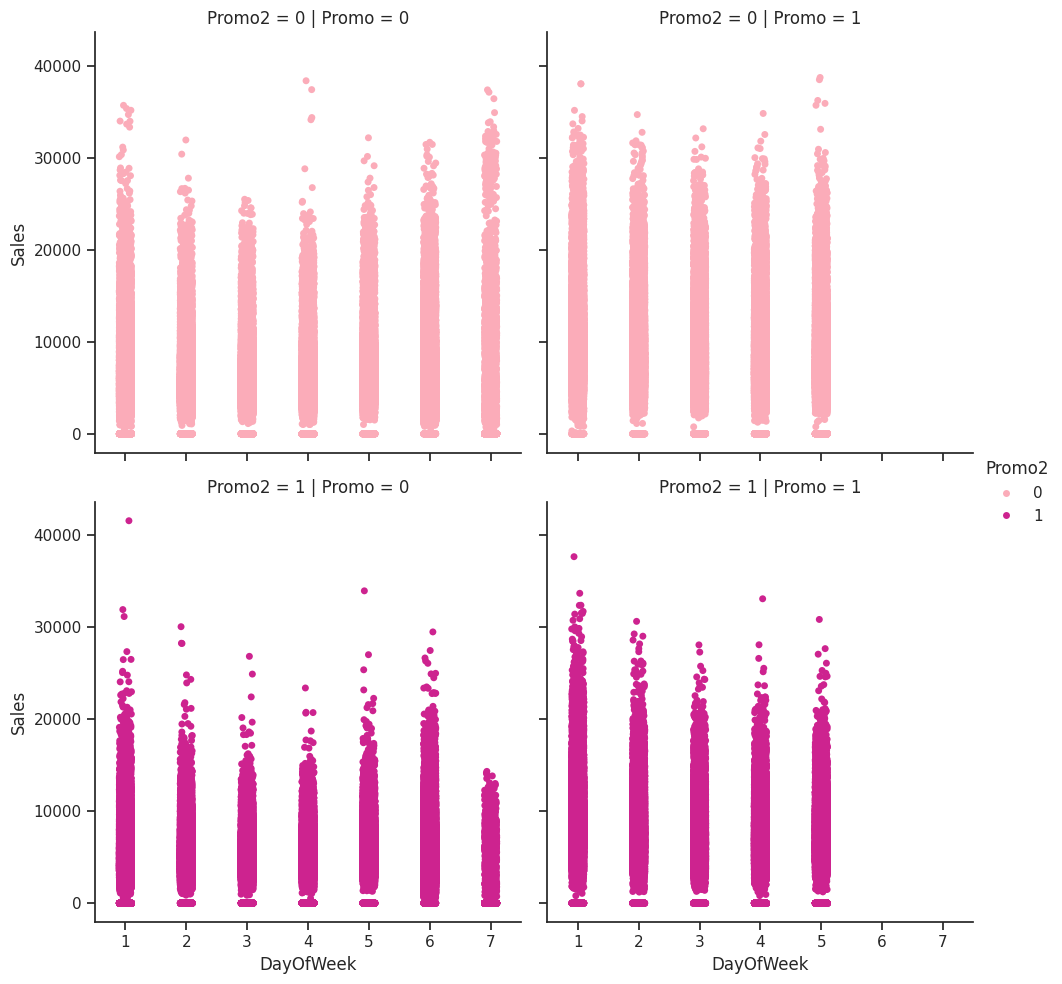

In [45]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales",
               col = 'Promo',
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

### 1.7 시각화를 통한 데이터 탐색 (히스토그램, 박스플롯, 산점도 등)

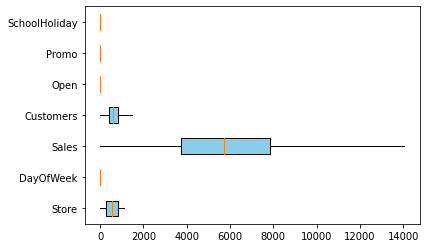

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(numeric_cols.values, vert=False, patch_artist=True, labels=numeric_cols.columns,
          showfliers = False, showcaps=False, boxprops = dict(facecolor="skyblue"))
plt.show()

<Axes: >

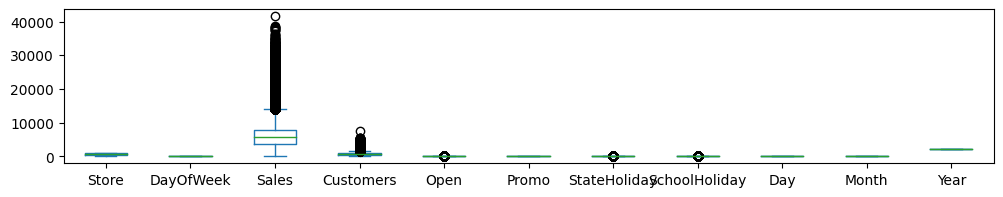

In [ ]:
train_1.plot(kind="box", figsize=(12,2))

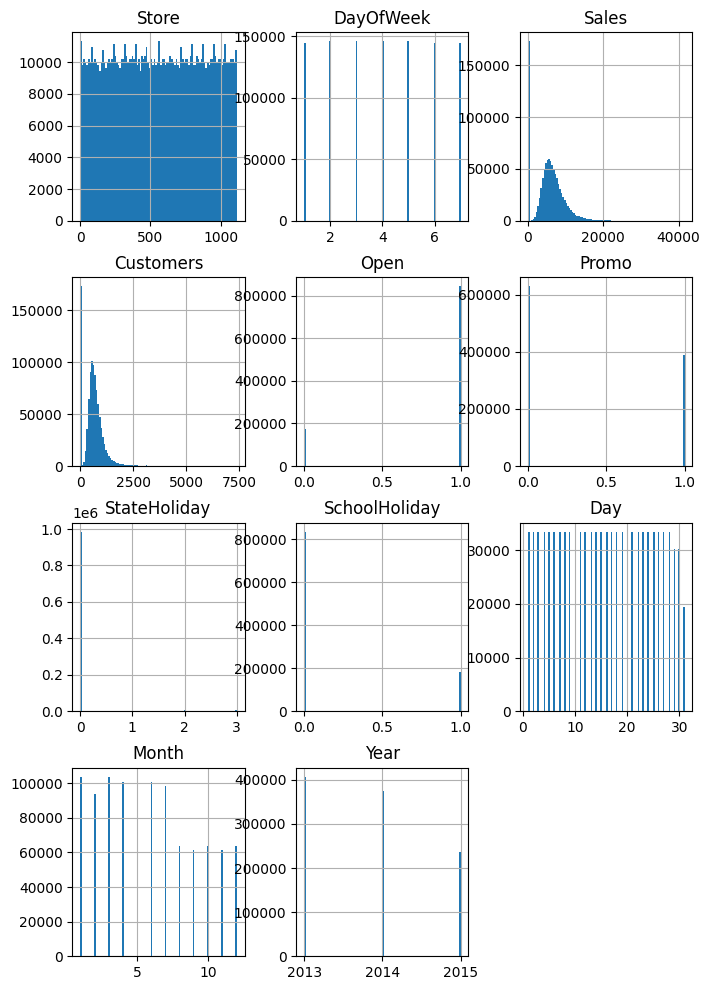

In [ ]:
train_1.hist(bins=100, figsize=(8,12));

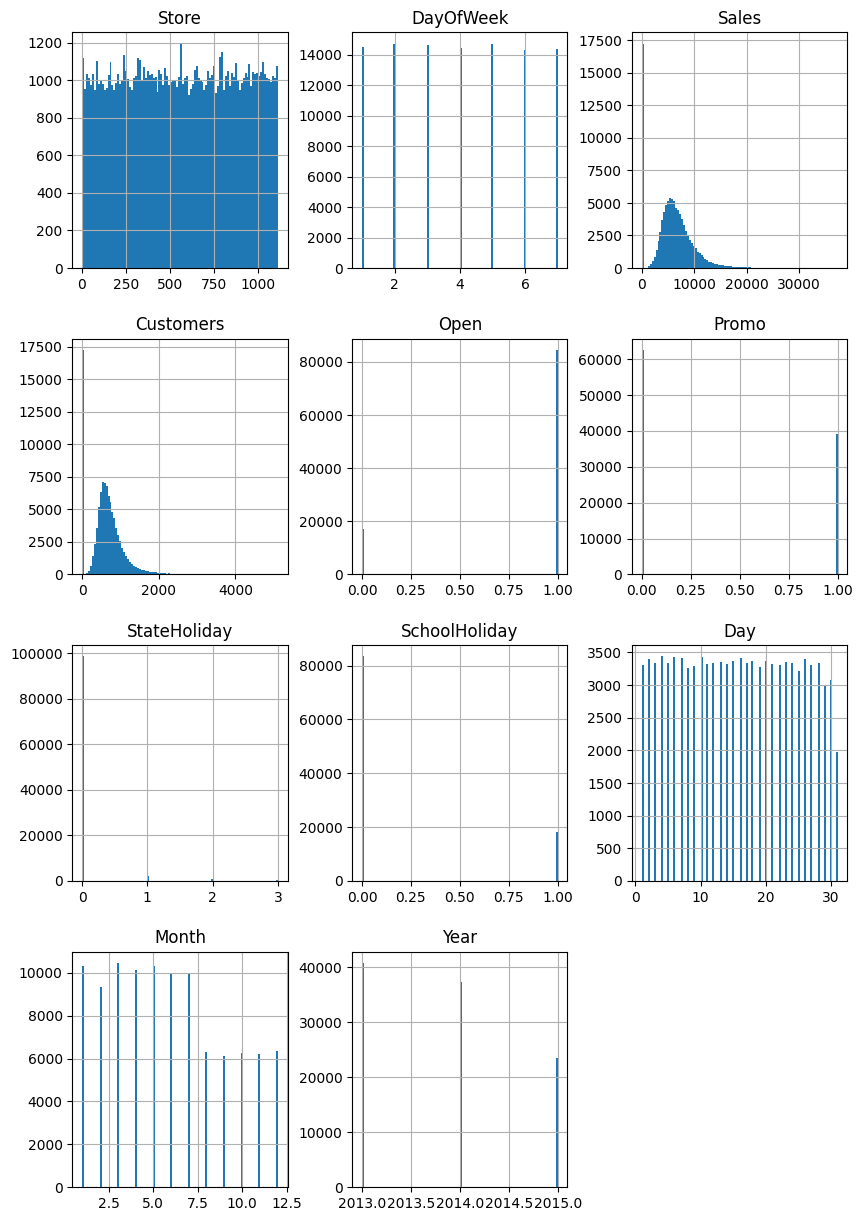

In [ ]:
train_1.sample(frac=0.1).hist(bins=100, figsize=(10,15));

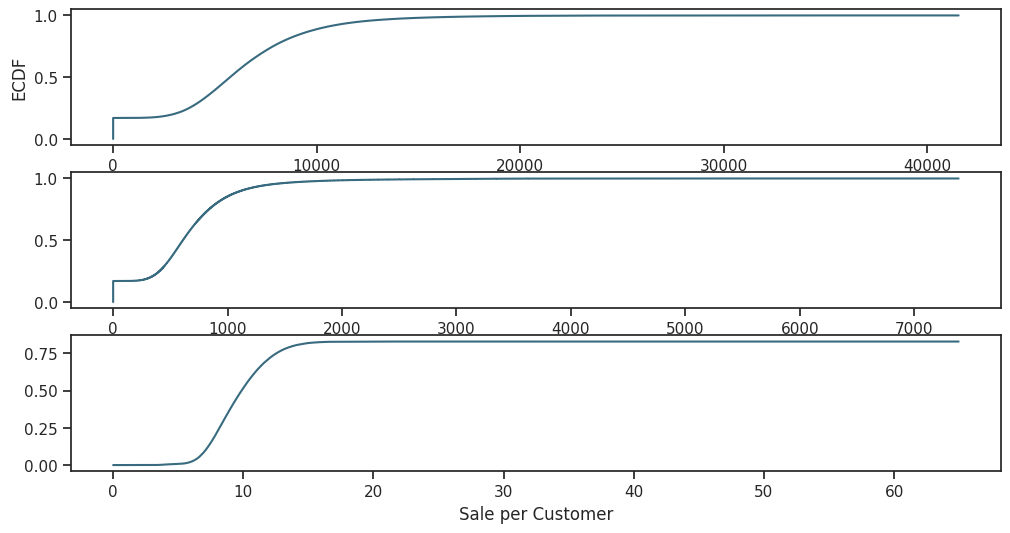

In [13]:
sns.set(style = "ticks")# to format into seaborn
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [32]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (1017209, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,Day,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,9.482883,31,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,9.194139,30,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,9.143403,29,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,8.948214,28,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,9.970588,27,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [33]:
# store types
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


In [34]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


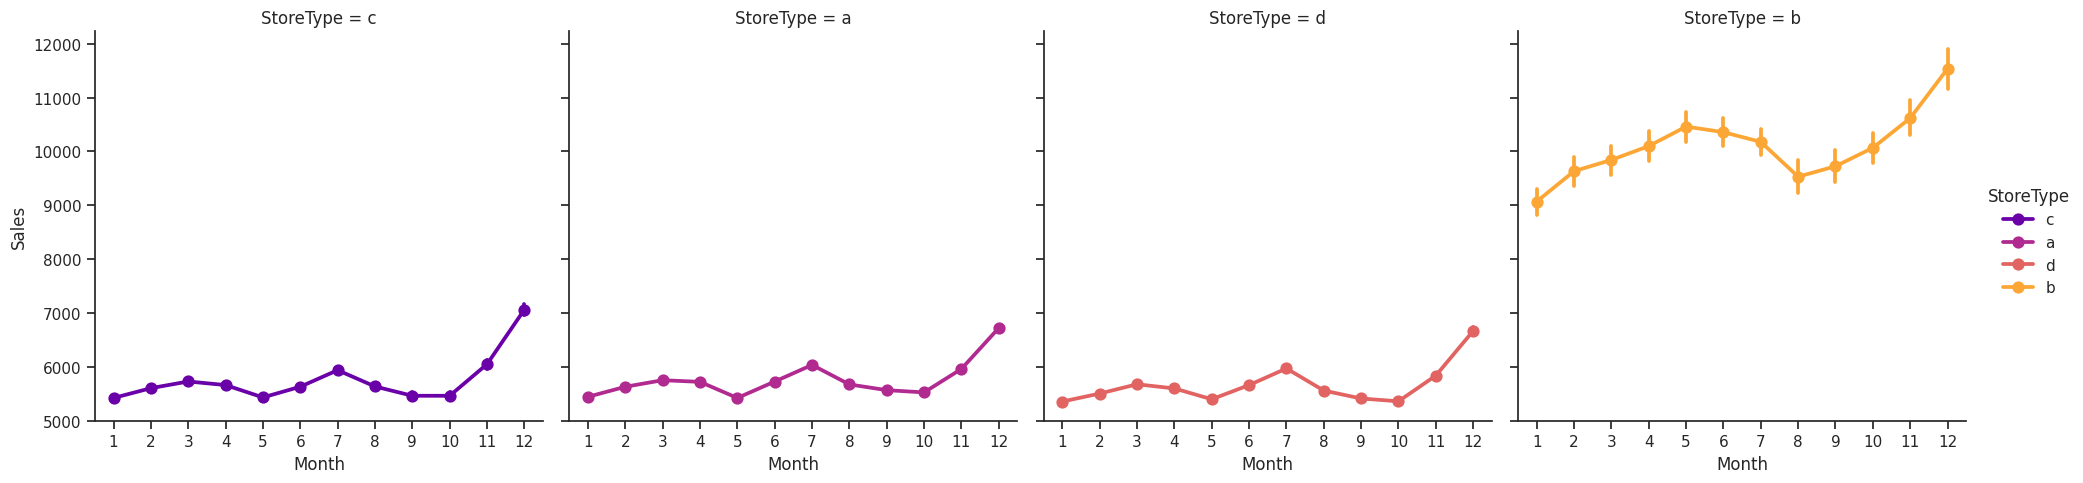

In [35]:
# sales trends
sns.catplot(data=train_store, x='Month', y="Sales",
            col='StoreType',  # per store type in cols
            palette='plasma',
            hue='StoreType',
            kind='point')  # 사용할 그래프 종류를 'point', 'bar', 'strip', 'swarm', 'box', 'violin', 또는 'boxen' 중에서 선택


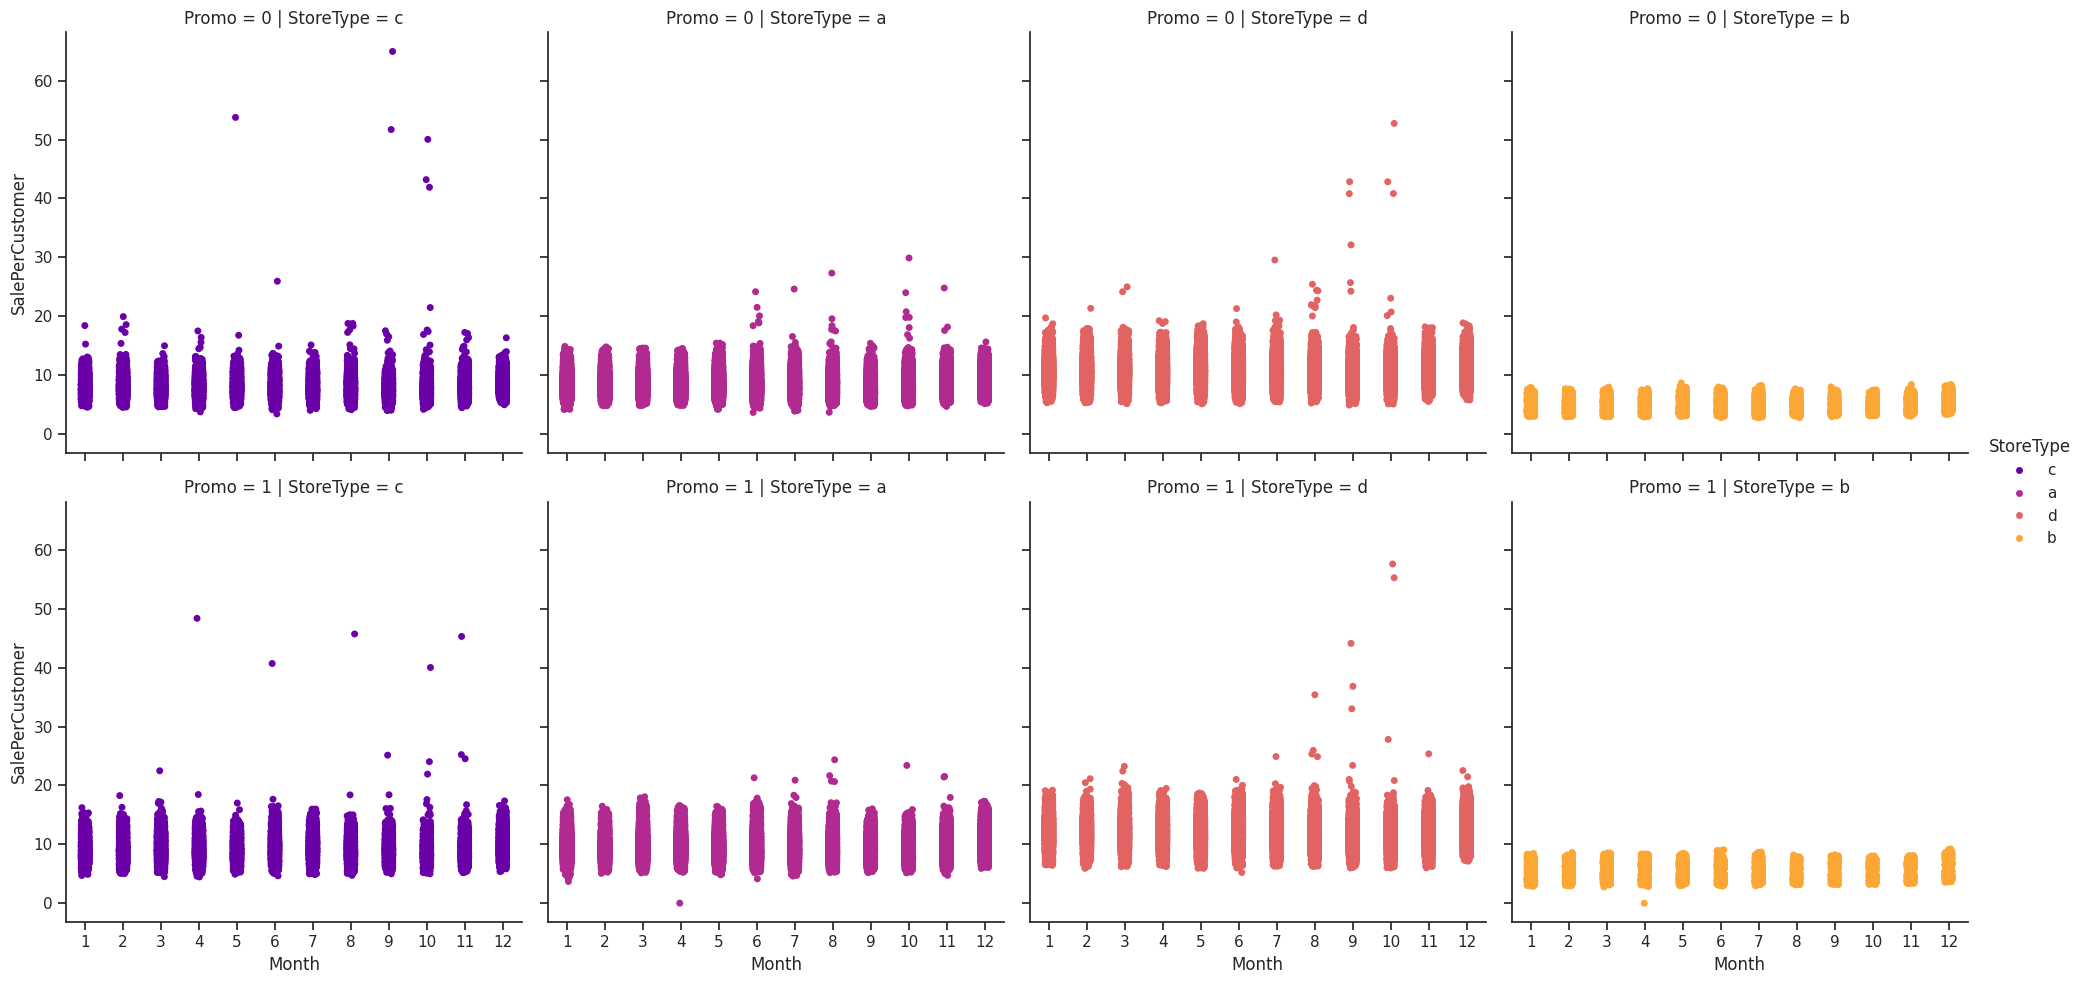

In [37]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

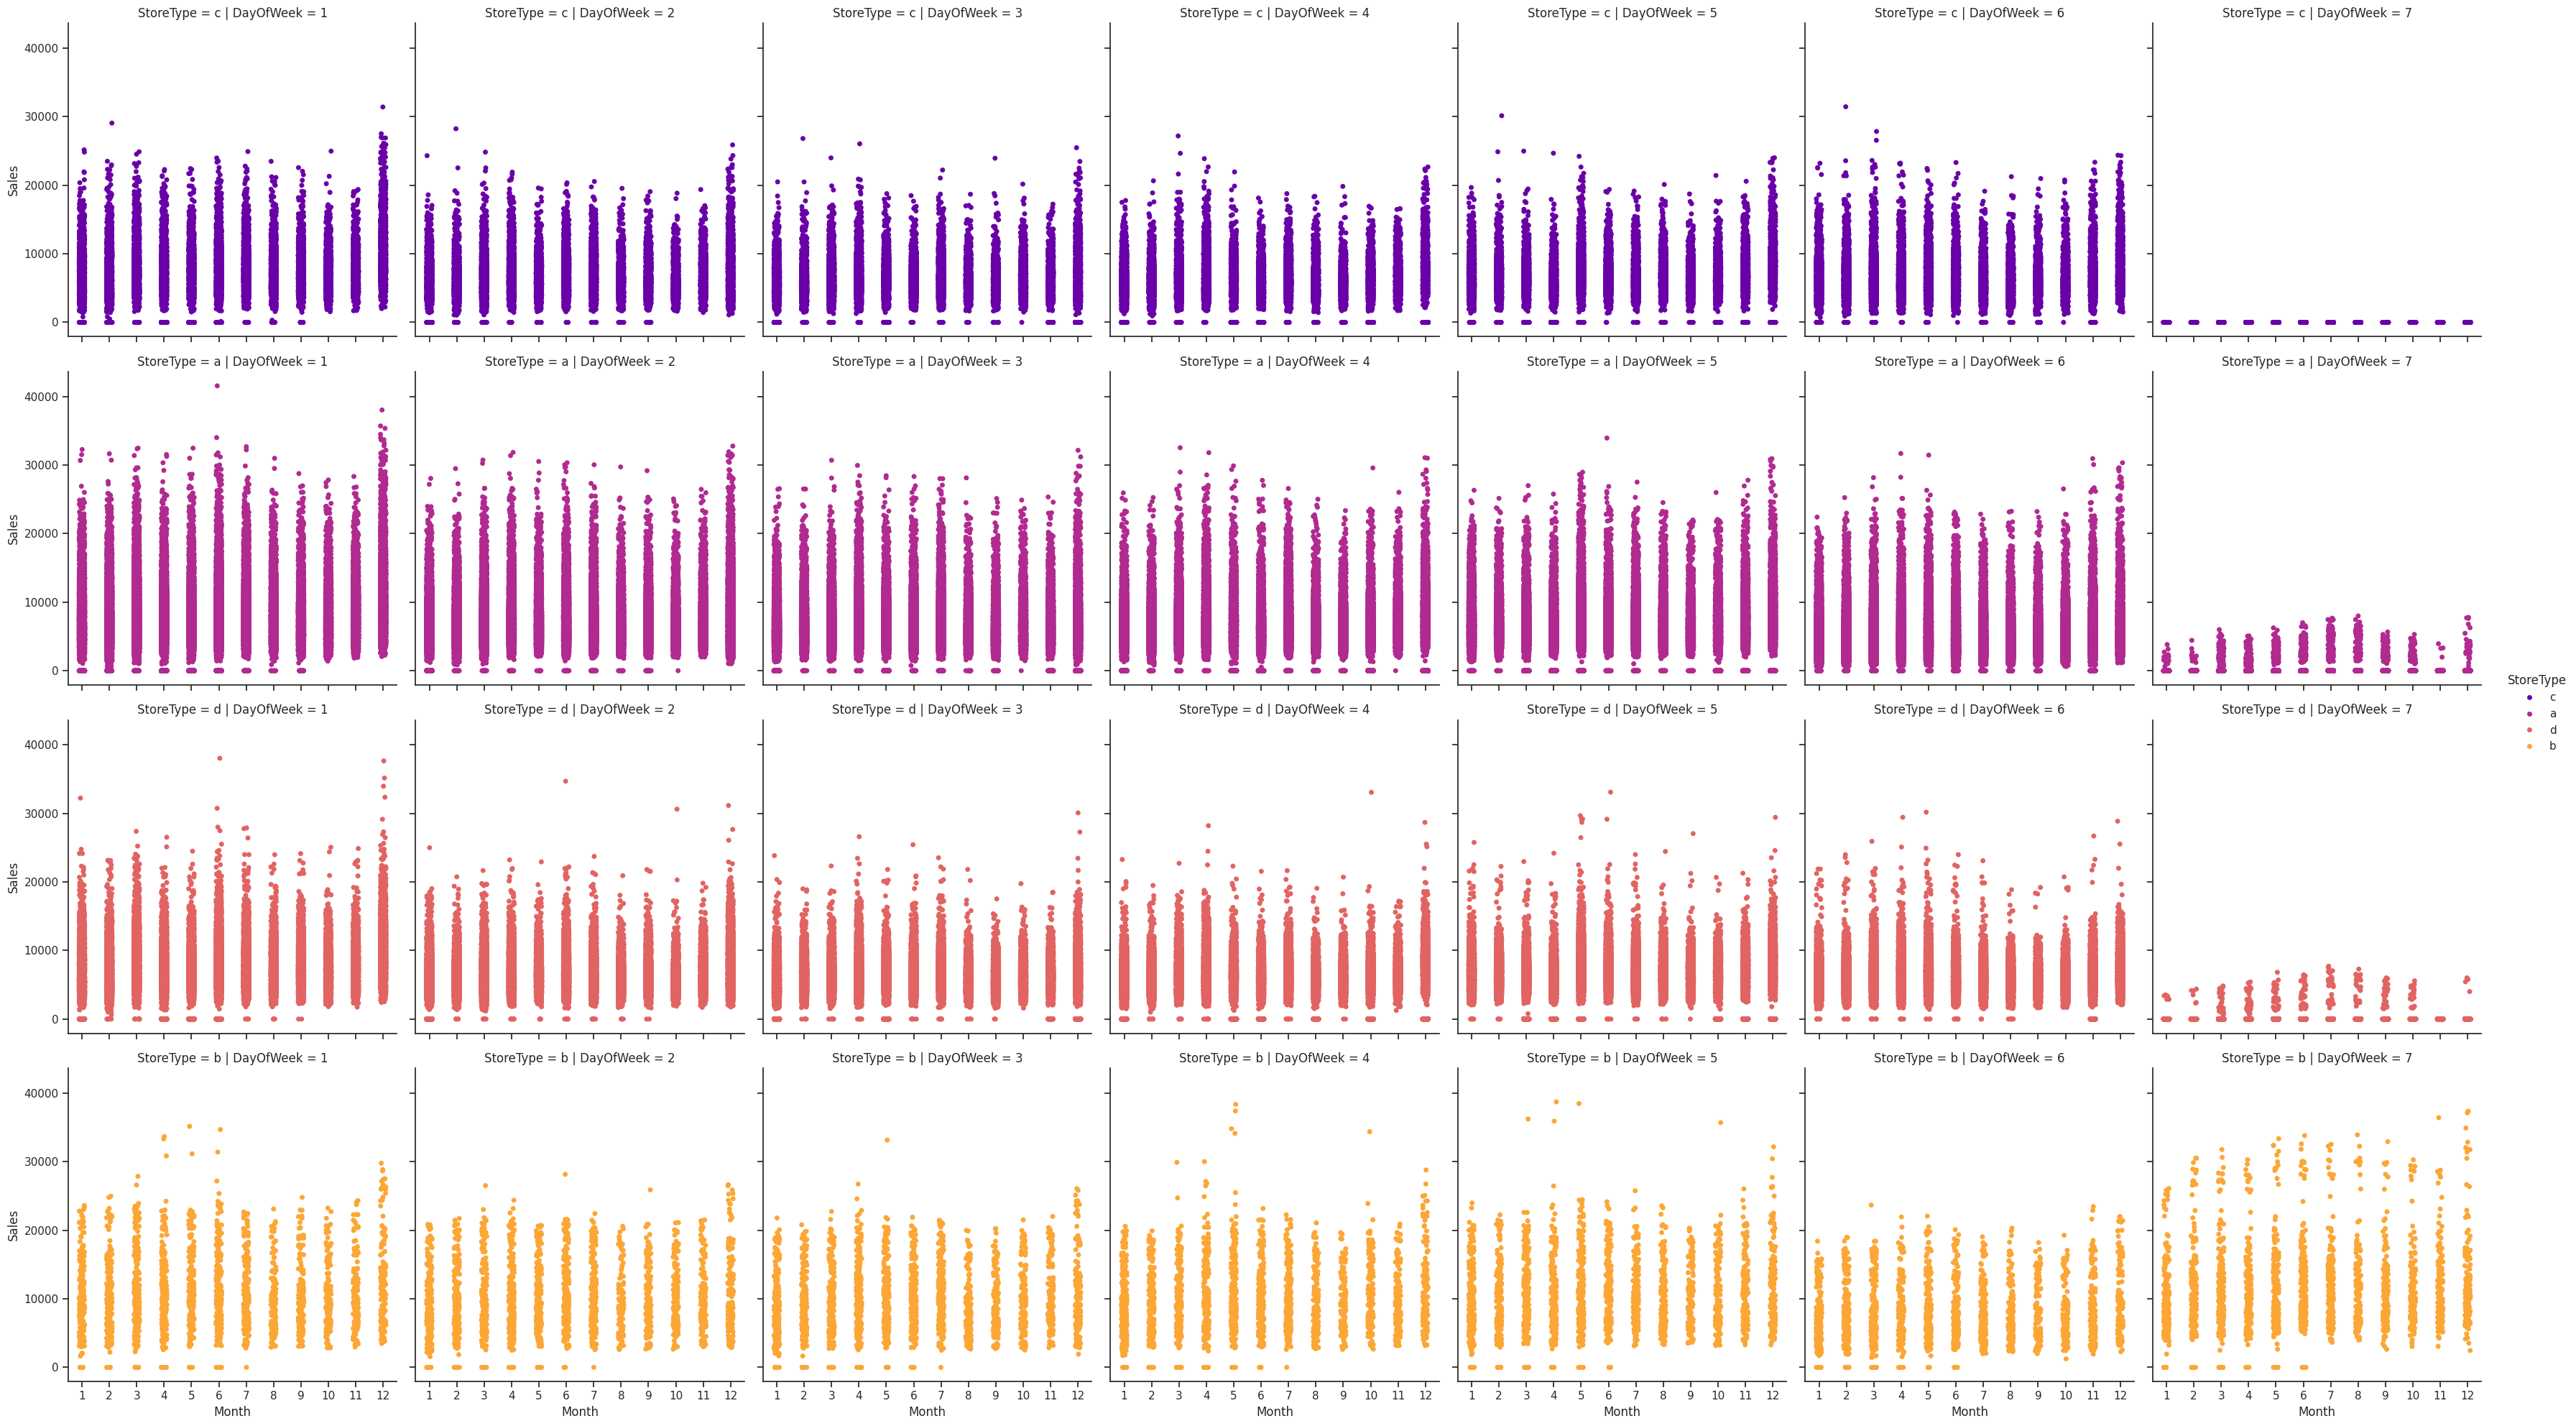

In [38]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales",
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

# 2. 추정 (3)
[✔️] 모집단의 특성 추정 (신뢰구간 계산) \
[✔️] 표본 크기 결정 \
[✔️] 추정 오차 분석 \



### 2.1 모집단의 특성 추정 (신뢰구간 계산)

In [46]:
corr_all

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,SalePerCustomer,Day,Month,Year,WeekOfYear,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
Store,1.000000,-0.000008,0.005126,0.024325,0.000058,0.000641,-0.021631,0.000023,0.001467,0.000290,0.001421,-0.026451,-0.032893,-0.008794,0.008488,0.011053,0.008520,0.008805,-0.008521
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.392925,-0.205388,-0.497698,0.005136,-0.005362,0.001937,-0.004880,-0.000025,0.000008,0.000007,0.000168,0.000208,0.000168,-0.000007,-0.000168
Sales,0.005126,-0.462125,1.000000,0.894711,0.452345,0.085124,0.658799,-0.011612,0.048768,0.023519,0.052946,-0.018869,-0.012431,0.002749,-0.091040,-0.044143,-0.091056,-0.002710,0.091081
Customers,0.024325,-0.386445,0.894711,1.000000,0.316169,0.071568,0.413080,-0.004473,0.038179,-0.001212,0.041404,-0.102362,-0.015188,0.000489,-0.150159,-0.098323,-0.150138,-0.000473,0.150143
Promo,0.000058,-0.392925,0.452345,0.316169,1.000000,0.067483,0.385055,-0.108325,-0.011747,0.024300,0.000572,0.000140,-0.000039,-0.000034,-0.000983,-0.001210,-0.000983,0.000051,0.001002
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.067483,1.000000,0.081181,0.030538,0.103282,-0.036535,0.071052,-0.003666,-0.001688,-0.001801,-0.006909,-0.006679,-0.006912,0.001801,0.006905
SalePerCustomer,-0.021631,-0.497698,0.658799,0.413080,0.385055,0.081181,1.000000,0.018082,0.006279,0.031639,0.011948,0.099888,-0.011677,-0.014623,0.088994,0.082121,0.088946,0.014652,-0.088921
Day,0.000023,0.005136,-0.011612,-0.004473,-0.108325,0.030538,0.018082,1.000000,0.012442,-0.002485,0.069624,0.000049,-0.000012,-0.000011,-0.000354,-0.000435,-0.000354,0.000013,0.000373
Month,0.001467,-0.005362,0.048768,0.038179,-0.011747,0.103282,0.006279,0.012442,1.000000,-0.269382,0.967034,0.003614,-0.001037,-0.000897,-0.025323,-0.031188,-0.025329,0.000970,0.025414
Year,0.000290,0.001937,0.023519,-0.001212,0.024300,-0.036535,0.031639,-0.002485,-0.269382,1.000000,-0.256619,0.000710,-0.000203,-0.000176,-0.004982,-0.006135,-0.004983,0.000927,0.005680


from matplotlib import pyplot as plt
_df_0['Store'].plot(kind='hist', bins=20, title='Store')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['DayOfWeek'].plot(kind='hist', bins=20, title='DayOfWeek')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Sales'].plot(kind='hist', bins=20, title='Sales')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Customers'].plot(kind='hist', bins=20, title='Customers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Store', y='DayOfWeek', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='DayOfWeek', y='Sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Sales', y='Customers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Customers', y='Promo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Store']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Store')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['DayOfWeek']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('DayOfWeek')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Sales']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Sales')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Customers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Customers')

from matplotlib import pyplot as plt
_df_12['Store'].plot(kind='line', figsize=(8, 4), title='Store')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['DayOfWeek'].plot(kind='line', figsize=(8, 4), title='DayOfWeek')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Sales'].plot(kind='line', figsize=(8, 4), title='Sales')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Customers'].plot(kind='line', figsize=(8, 4), title='Customers')
plt.gca().spines[['top', 'right']].set_visible(False)

In [48]:
from scipy import stats
# Sales와 Customers의 평균값에 대한 신뢰구간

sales_data = np.array(train_store['Sales'])
confidence = 0.95
confidence_interval = stats.t.interval(confidence, len(sales_data)-1, loc=np.mean(sales_data), scale=stats.sem(sales_data))
print(f"Sales의 {confidence*100}% 신뢰구간: {confidence_interval}")


Sales의 95.0% 신뢰구간: (5766.337347716876, 5781.30059689431)


Sales의 표본 평균 (점추정): 5773.818972305593
95% 신뢰구간: (5766.337356619179, 5781.3005879920065)


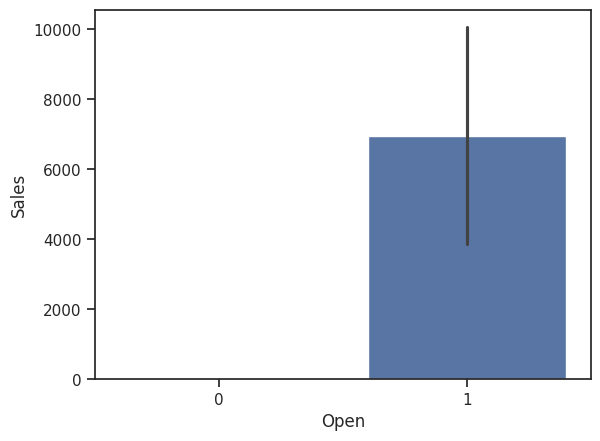

In [49]:
import numpy as np
import seaborn as sns

# 막대그래프를 통한 신뢰 구간 확인, 이탈률에 따른 월별 요금
sns.barplot(data=train_store, x="Open", y="Sales", ci="sd")  # errorbar 대신 ci를 사용하고 sd(표준편차)를 기반으로 신뢰구간 표시

# Sales 데이터 추출
sales_data = train_store['Sales']

# 점추정: Sales의 표본 평균 계산
point_estimate = sales_data.mean()
print(f"Sales의 표본 평균 (점추정): {point_estimate}")

# 구간 추정: 95% 신뢰구간 계산
# 표본 크기, 표본 평균, 표본 표준편차 계산
sample_size = len(sales_data)
sample_mean = sales_data.mean()
sample_std = np.std(sales_data, ddof=1)

# 신뢰수준에 따른 Z값 계산 (여기서는 95%를 기준으로 함)
confidence_level = 0.95
z_value = stats.norm.ppf((1 + confidence_level) / 2)

# 추정 오차 계산
margin_of_error = z_value * (sample_std / np.sqrt(sample_size))

# 신뢰구간 계산
confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
print(f"95% 신뢰구간: {confidence_interval}")

In [50]:
sales_data = train_store['Sales']

# 점추정: `Sales`의 표본 평균 계산
point_estimate_sales = sales_data.mean()
print("점추정 (Sales 평균):", point_estimate_sales)

점추정 (Sales 평균): 5773.818972305593


In [51]:
# 표본 크기, 표본 평균, 표본 표준편차 계산
sample_size_sales = len(sales_data)
sample_mean_sales = sales_data.mean()
sample_std_sales = np.std(sales_data, ddof=1)

# 95% 신뢰구간 계산 (Z-score 사용)
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)
margin_of_error = z_score * (sample_std_sales / np.sqrt(sample_size_sales))

confidence_interval = (sample_mean_sales - margin_of_error, sample_mean_sales + margin_of_error)
print("95% 신뢰구간:", confidence_interval)


95% 신뢰구간: (5766.337356619179, 5781.3005879920065)


- 신뢰구간 계산

In [58]:
from scipy import stats
# 신뢰구간 계산 (t-분포 사용)
# stats.t.ppf 로 t_critical 구하기
confidence_level = 0.95
alpha = 1 - confidence_level

t_critical = stats.t.ppf(1 - alpha/2, df=sample_size-1)  # t-분포의 임계값
margin_of_error = t_critical * (sample_std / np.sqrt(sample_size))

confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

point_estimate, confidence_interval

(5773.818972305593, (4810.2997657388905, 6737.338178872295))

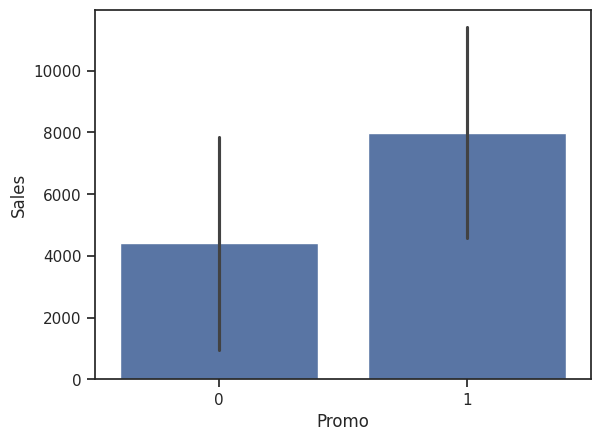

Promo 활성화 시 Sales의 평균: 7991.152045969903
Promo 비활성화 시 Sales의 평균: 4406.050805160786
Promo 활성화 시 95% 신뢰구간: (7980.395079881327, 8001.90901205848)
Promo 비활성화 시 95% 신뢰구간: (4397.544403566801, 4414.557206754771)


In [59]:
# 막대그래프를 통한 신뢰 구간 확인, Promo에 따른 Sales
sns.barplot(data=train_store, x="Promo", y="Sales", ci="sd")  # sd(표준편차)를 기반으로 신뢰구간 표시
plt.show()

# Promo 활성화와 비활성화에 따른 Sales 데이터 추출
sales_data_promo = train_store[train_store['Promo'] == 1]['Sales']
sales_data_no_promo = train_store[train_store['Promo'] == 0]['Sales']

# Promo 활성화된 날의 Sales 평균 계산 (점추정)
point_estimate_promo = sales_data_promo.mean()

# Promo 비활성화된 날의 Sales 평균 계산 (점추정)
point_estimate_no_promo = sales_data_no_promo.mean()

print(f"Promo 활성화 시 Sales의 평균: {point_estimate_promo}")
print(f"Promo 비활성화 시 Sales의 평균: {point_estimate_no_promo}")

# 각 조건에 대한 95% 신뢰구간 계산
def calculate_confidence_interval(data):
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)
    sample_size = len(data)
    z_value = stats.norm.ppf(0.975)  # 95% 신뢰구간
    margin_of_error = z_value * (sample_std / np.sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)
    return confidence_interval

confidence_interval_promo = calculate_confidence_interval(sales_data_promo)
confidence_interval_no_promo = calculate_confidence_interval(sales_data_no_promo)

print(f"Promo 활성화 시 95% 신뢰구간: {confidence_interval_promo}")
print(f"Promo 비활성화 시 95% 신뢰구간: {confidence_interval_no_promo}")

### 2.2 표본 크기 결정

In [57]:
import numpy as np
from statsmodels.stats.power import TTestIndPower

# 예시 파라미터
effect_size = 0.5  # 작은 효과 크기
alpha = 0.05  # 유의 수준
power = 0.8  # 1 - 베타, 검정력

# 표본 크기 계산
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
print(f"필요한 표본 크기: {np.ceil(sample_size)}")

필요한 표본 크기: 64.0


In [60]:
# 모집단의 평균과 표준편차 추정
mean_sales = train_store['Sales'].mean()
std_sales = train_store['Sales'].std()

print(f"추정된 모집단 평균 판매량: {mean_sales}")
print(f"추정된 모집단 판매량의 표준편차: {std_sales}")

추정된 모집단 평균 판매량: 5773.818972305593
추정된 모집단 판매량의 표준편차: 3849.926175234759


In [64]:
# 예상 margin_of_error와 confidence_level 설정 (5% 오차, 95% 신뢰수준)
margin_of_error = 0.10
confidence_level = 0.90
z_value = stats.norm.ppf((1 + confidence_level) / 2)

# 필요한 표본 크기 계산
required_sample_size = (z_value * std_sales / margin_of_error) ** 2
print(f"필요한 표본 크기: {int(required_sample_size)}")

필요한 표본 크기: 4010137989


### 2.3 추정 오차 분석

- 신뢰 구간(Confidence Interval): 주어진 신뢰 수준(예: 95%)에서 모수가 포함될 것으로 예상되는 값의 범위입니다. 신뢰 구간이 좁을수록 추정치의 정확도가 높습니다.
- 표준 오차(Standard Error): 표본 평균의 표준 편차로, 표본 크기가 커질수록 감소합니다.

In [62]:
# 신뢰 구간 계산을 위한 신뢰수준 설정
confidence_interval = stats.norm.interval(confidence_level, loc=mean_sales, scale=std_sales/np.sqrt(len(train_store)))

print(f"{confidence_level*100}% 신뢰 구간: {confidence_interval}")


95.0% 신뢰 구간: (5766.337356619179, 5781.3005879920065)


- 해석
  - 평균 판매량: 모집단의 평균 판매량이 약 5773.82로 추정된다. 이는 매장의 하루 평균 판매량이 대략 이 수치를 중심으로 분포할 것으로 예상할 수 있다.
  - 표준편차: 판매량 데이터의 표준편차가 약 3849.93으로, 판매량의 분포가 평균값을 중심으로 상당히 넓게 퍼져 있음을 의미힌다. 즉, 매장별 판매량의 변동이 크다는 것을 알 수 있습니다. 이는 각 매장의 위치, 프로모션 활동, 지역 행사, 계절성 등 다양한 요인에 의해 판매량이 크게 영향을 받을 수 있음을 시사한다.
- 추가적인 분석 방법
  - 데이터 세분화: 판매량의 변동성이 크기에, 전체 데이터를 세분화하여 분석. 예를 들어, 지역별, 프로모션 유무별, 계절별로 나누어 분석함으로써 더 정확한 특성을 파악할 수 있다. 이를 통해 특정 조건에서의 판매 예측 정확도를 높일 수 있을 것이다

  - 신뢰구간 활용: 주어진 표준편차를 바탕으로, 판매량 예측에 대한 신뢰구간을 계산하여 제시하기. 이를 통해 판매량 예측의 불확실성을 정량화하고, 관리자들이 보다 정보에 기반한 의사결정을 할 수 있도록 도울 수 있을 것이다.

  - 부트스트랩 방법: 제한된 데이터로부터 추가적인 정보를 추출하기 위해, 부트스트랩 방법을 활용할 수 있다. 이는 실제 데이터로부터 복원 추출을 통해 여러 번 표본을 생성하고, 이들 표본에 대한 통계량을 계산하여 모집단의 통계량을 더 정확하게 추정하는 데 도움이 될 수 있다.

  - 모델 기반 접근: 머신러닝 모델을 활용하여 판매량을 예측하는 것도 고려할 수 있다. 이 경우, 시계열 분석, 회귀 분석, 랜덤포레스트 등 다양한 모델을 실험하여 가장 정확한 예측 결과를 제공하는 모델을 선택할 수 있습니다. 모델 기반 접근 방법은 판매량의 변동성을 포착하고, 다양한 요인이 판매량에 미치는 영향을 이해하는 데 도움 줄 수 있겠지....😭

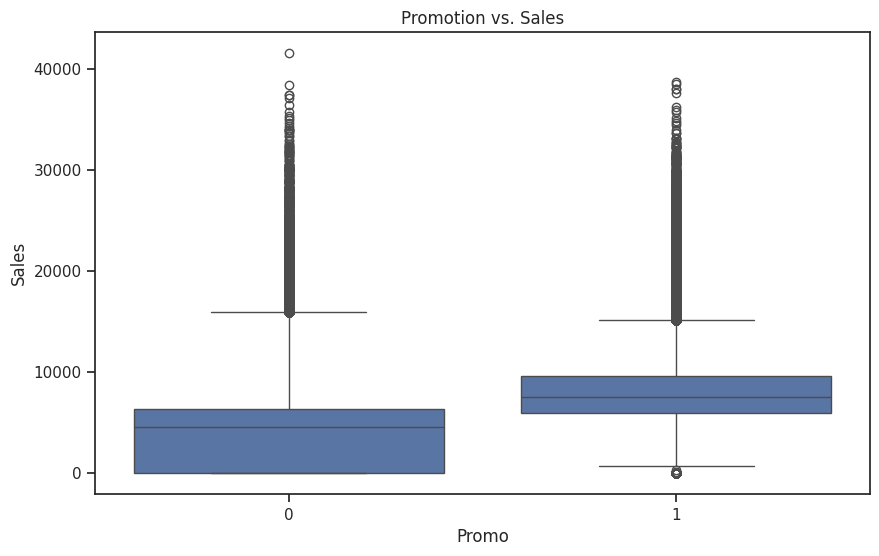

In [66]:
# 프로모션 유무에 따른 판매량 비교
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=train_store)
plt.title('Promotion vs. Sales')
plt.show()

# 3. 검정 (5)

 [✔️] 가설 설정: 귀무가설과 대립가설 \
 [✔️] 적절한 검정 방법 선택: t-검정, 카이제곱 검정, ANOVA 등 \
 [✔️] 검정 수행 및 결과 해석 \
 [✔️] 검정의 유의성 평가: p-값, 신뢰구간 \
[✔️] 검정 결과에 대한 해석 및 결론 도출 \

### 3.1  가설 설정: 귀무가설과 대립가설



*** Promo와 Sales 사이에 관계가 있는지 확인 ***

- 귀무가설 (H0): Promo가 Sales에 영향을 미치지 않는다. (Promo와 Sales 사이에는 관계가 없다.)
- 대립가설 (H1): Promo가 Sales에 영향을 미친다. (Promo와 Sales 사이에는 양의 관계가 있다.)

* t-통계량: 두 그룹 간의 평균 이용 기간에 매우 큰 차이가 있음을 나타냅니다. t-통계량이 음수이므로 이탈한 고객 그룹의 평균 이용 기간이 더 짧습니다.
* p-값: 매우 낮은 p-값은 귀무가설(통신사 이용 기간이 고객 이탈 여부에 영향을 미치지 않는다)을 기각하는 데 충분합니다. 즉, 통신사 이용 기간과 고객의 이탈 여부는 통계적으로 유의미한 관련이 있음을 의미합니다.
* 자유도: 자유도는 두 표본의 분산이 다르다고 가정했을 때 계산됩니다. 이 경우 높은 자유도는 t-분포가 정규분포에 가깝다는 것을 나타냅니다.

### 3.2 적절한 검정 방법 선택
- t-검정, 카이제곱 검정, ANOVA 등



In [75]:
# Promo 여부에 따른 Sales 분석을 위한 데이터 추출
promo_yes = train_store[train_store['Promo'] == 1]['Sales']
promo_no = train_store[train_store['Promo'] == 0]['Sales']

- t-검정 수행
  - stats.ttest_ind 함수는 두 독립 표본 그룹 간의 평균 차이를 검정하는 데 사용됩니다.
  - equal_var=False는 두 그룹의 분산이 동일하지 않다는 가정 하에 검정을 수행하라는 의미입니다.
  - 이는 보통 두 표본 크기가 다르거나 데이터의 분포가 서로 다를 때 사용됩니다.
- t_statistic은 t-검정 통계량으로, 두 그룹 간 평균 차이의 크기와 방향을 나타냅니다.
- p_value는 귀무가설이 참일 때 관측된 결과가 발생할 확률입니다.
  - 이 값이 매우 작으면(보통 0.05 이하), 두 그룹 간 평균 차이가 통계적으로 유의미하다고 해석할 수 있습니다.

- 적절한 검정 방법 선택:

  - Promo와 Sales의 관계를 평가하기 위해 t-검정 사용
  - Promo가 두 가지 값을 가지므로 (프로모션이 있는 날과 없는 날), 독립된 두 표본 t-검정을 사용할 수 있음

In [53]:
train_store['Promo'].value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

In [79]:
# PhoneService를 이용하는 고객과 그렇지 않은 고객의 이탈률 데이터 추출
promo_yes = train_store[train_store['Promo'] == 1]['Sales']
promo_no = train_store[train_store['Promo'] == 0]['Sales']

# 등분산성 검정
_, p_value_homogeneity = stats.levene(promo_yes, promo_no)

# 등분산성 검정 결과에 따라 적절한 t-검정 수행

# 등분산성이 가정되는 경우
equal_val = True
if p_value_homogeneity < 0.05 :
    # 등분산성이 가정되지 않는 경우
    equal_val = False

t_statistic, p_value =  stats.ttest_ind(promo_yes, promo_no, equal_var=equal_val)
p_value_homogeneity, t_statistic

(0.0, 512.3755316936371)

* 유의성 판단: p-value가 유의 수준 선 아래에 위치하면, 해당 검정 결과가 통계적으로 유의미함을 나타냅니다.
* 예를 들어, t-검정의 p-value가 0.05 아래이면, 두 그룹 간의 평균 차이가 유의미하다고 해석할 수 있습니다.

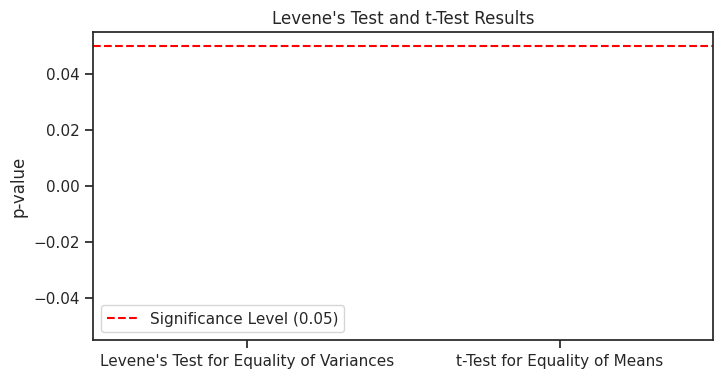

In [78]:
# 등분산성 검정 결과와 t-검정 결과를 시각화하기 위한 데이터 준비
labels = ['Levene\'s Test for Equality of Variances', 't-Test for Equality of Means']
values = [p_value_homogeneity, p_value]

# 시각화
plt.figure(figsize=(8, 4))
plt.bar(labels, values, color=['blue', 'green'])
plt.ylabel('p-value')
plt.title('Levene\'s Test and t-Test Results')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.legend()
plt.show()

### 3.3  검정 수행 및 결과 해석

In [80]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 여러 집단의 평균 비교를 위한 분석 예시: 고객의 인터넷 서비스 타입별 월별 요금
# MonthlyCharges ~ C(InternetService) => 'InternetService' 열과 'MonthlyCharges' 열을 사용

# 분산분석(ANOVA) 수행
model = ols("Sales ~ C(Promo)", data=train_store).fit()
# anova_lm
sm.stats.anova_lm(model, typ=2).round(2)

,sum_sq,df,F,PR(>F)
C(Promo),3.084989e+12,1.0,261680.52,0.0
Residual,1.199200e+13,1017207.0,NaN,NaN


* ANOVA 결과를 시각화
* 각 인터넷 서비스 타입(DSL, Fiber optic, No)별 월별 요금의 분포를 비교할 수 있습니다.
* 박스플롯에서는 중앙값, 사분위수, 이상치 등의 정보를 한눈에 파악할 수 있으며, 이를 통해 집단 간의 평균 차이뿐만 아니라 전반적인 분포의 차이도 확인할 수 있습니다.

<Axes: xlabel='Sales', ylabel='Count'>

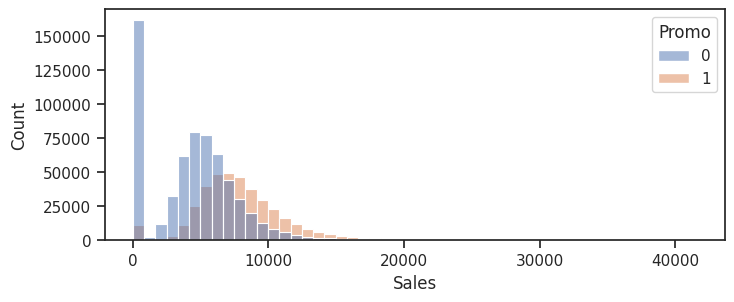

In [81]:
# histplot
plt.figure(figsize=(8, 3))
sns.histplot(data=train_store, x="Sales", hue="Promo", bins=50)

<Axes: xlabel='Sales'>

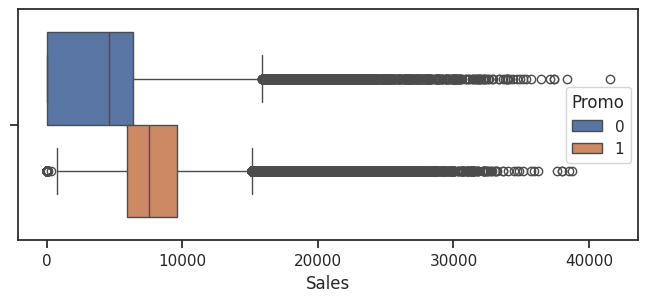

In [83]:
# ANOVA 결과 시각화 boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(data=train_store, x="Sales", hue="Promo")

<Axes: xlabel='Sales'>

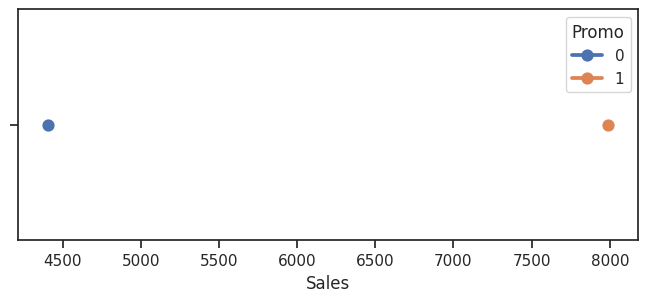

In [82]:
# pointplot
plt.figure(figsize=(8, 3))
sns.pointplot(data=train_store, x="Sales", hue="Promo", errorbar="ci")

In [77]:
from scipy.stats import ttest_ind

promo_sales = train_store[train_store['Promo'] == 1]['Sales']
no_promo_sales = train_store[train_store['Promo'] == 0]['Sales']

t_stat, p_value = ttest_ind(promo_sales, no_promo_sales, equal_var=False)
print(f"t-통계량: {t_stat}, p-값: {p_value}")

t-통계량: 512.3755316936371, p-값: 0.0


### 3.4 검정의 유의성 평가: p-값, 신뢰구간
1. p값을 통한 검정 유의성 평가:
- p값은 귀무 가설(H0) 하에서 관측된 데이터, 혹은 더 극단적인 데이터가 발생할 확률입니다. p값이 매우 낮다는 것은 귀무 가설 하에서 우리가 관측한 결과가 발생할 가능성이 매우 낮음을 의미합니다.
- **유의 수준(α)**은 보통 0.05로 설정되며, 이는 연구자가 용인할 수 있는 최대 오류 확률입니다. p값이 α보다 작을 경우, 귀무 가설을 기각하고 대안 가설(H1)을 채택합니다.
2. 신뢰구간을 통한 검정 유의성 평가:
- 신뢰구간은 모집단 파라미터(예: 평균, 비율 등)에 대한 추정 범위로, 특정 신뢰 수준(예: 95%) 하에서 그 파라미터가 존재할 것으로 예상되는 구간입니다.
- 신뢰구간이 특정 값(예: 0의 차이, 또는 특정 기준값)을 포함하지 않을 경우, 이는 그 파라미터가 통계적으로 유의미하게 그 값과 다르다는 것을 의미할 수 있습니다.

In [85]:
# Promo가 1인 경우와 0인 경우의 Sales 데이터
promo_sales = train_store[train_store['Promo'] == 1]['Sales']
no_promo_sales = train_store[train_store['Promo'] == 0]['Sales']

# 평균 차이 계산
mean_difference = np.mean(promo_sales) - np.mean(no_promo_sales)

# 표준 오차 계산
se_promo = stats.sem(promo_sales, ddof=1)
se_no_promo = stats.sem(no_promo_sales, ddof=1)
se_difference = np.sqrt(se_promo**2 + se_no_promo**2)

# 신뢰구간 계산 (95% 신뢰수준)
confidence_level = 0.95
df = min(len(promo_sales), len(no_promo_sales)) - 1  # 자유도
t_critical = stats.t.ppf((1 + confidence_level) / 2, df)
margin_of_error = t_critical * se_difference

# 신뢰구간 출력
lower_bound = mean_difference - margin_of_error
upper_bound = mean_difference + margin_of_error
print(f"95% 신뢰구간: ({lower_bound}, {upper_bound})")

95% 신뢰구간: (3571.3872931407623, 3598.8151884774725)


**Rossmann Dataset**

1. p값 해석
- Promo 변수에 따른 Sales의 t-통계량이 512.3755, p-값이 0.0으로 나타났습니다. 이는 프로모션이 있을 때와 없을 때의 Sales가 통계적으로 유의미하게 다르다는 강력한 증거입니다. 유의 수준 0.05보다 훨씬 작으므로, 귀무 가설(H0: 프로모션 전후의 Sales에 차이가 없다)을 기각합니다.

2. 신뢰구간 해석
- 신뢰구간이 0을 포함하지 않고 전적으로 양수인 경우, 이는 프로모션이 Sales를 통계적으로 유의미하게 증가시킨다는 것을 나타냅니다.

[95% 신뢰구간: (3571.3872931407623, 3598.8151884774725)]

- 이 신뢰구간은 프로모션이 있는 경우의 평균 판매량이 프로모션이 없는 경우보다 평균적으로 약 3571.39에서 3598.82만큼 더 높다는 것을 의미합니다. 신뢰구간이 전적으로 양수 범위에 있으므로, 프로모션의 효과가 통계적으로 유의미하게 판매량을 증가시킨다는 것을 알 수 있습니다. 즉, 이 데이터를 바탕으로 볼 때, 프로모션은 실제로 판매량에 긍정적인 영향을 미칩니다.

### 3.5 검정 결과에 대한 해석 및 결론 도출

[t-통계량: 512.3755316936371, p-값: 0.0] \
- 검정의 유의성 평가:
  - p-값 : 0.0
  - 실제로는 매우 작은 값이지만, 표현상 0. 이는 관측된 데이터가 귀무 가설(프로모션의 유무가 판매량에 영향을 주지 않는다)을 지지하지 않음을 의미 \
➡️ t-통계량의 큰 값은 프로모션 유무에 따른 판매량 차이가 통계적으로 매우 유의하다는 것을 나타냄

- 검정 결과에 대한 해석 및 결론 도출:
  - 프로모션이 있는 경우와 없는 경우의 판매량에는 통계적으로 유의미한 차이가 있다.
  - p-값이 매우 작기 때문에, 우리는 귀무 가설을 기각하고 대립 가설(프로모션의 유무가 판매량에 영향을 준다)을 채택한다. \
➡️ 이 결과는 프로모션이 판매량을 증가시키는 데 긍정적인 영향을 미친다는 강력한 증거를 제공한다.\
➡️ 프로모션은 상당한 양의 추가 판매를 생성. 이는 Rossmann과 같은 소매업체에 있어 프로모션 전략이 매우 중요함을 시사

[ANOVA 결과] \
- 검정의 유의성 평가:
  - F 값은 261680.52로, 프로모션 범주 간에 매우 큰 차이가 있다는 것을 나타냅니다.
PR(>F) 값이 0.0으로, 이 역시 p-값이 매우 작아 귀무 가설을 기각하는 것을 지지합니다.
검정 결과에 대한 해석 및 결론 도출:
  - ANOVA 결과 역시 t-검정의 결과와 일치하여, 프로모션의 유무가 판매량에 통계적으로 유의미한 영향 미침을 시사.
  - PR(>F) 값이 매우 작기 때문에, 다시 한번 귀무 가설을 기각하고 대립 가설을 채택한다. 이는 프로모션이 판매량에 유의미한 영향을 미친다는 것을 의미
  - (+)ANOVA는 두 그룹 이상의 평균을 비교할 때 사용되므로, 이 경우 프로모션 유무라는 한 가지 요인만을 고려한 단일 요인 분석에서도 프로모션이 판매량에 중요한 영향을 미친다는 결론 지지.

[종합 결론]
- 두 통계적 검정 모두 프로모션이 Rossmann의 판매량에 긍정적인 영향을 미친다는 것을 강력하게 지지.
- 이 분석은 Rossmann의 프로모션 전략이 고객의 구매 행위에 긍정적인 영향을 미치며, 따라서 판매 촉진에 중요한 역할을 한다는 점을 강조한다.
- 이러한 통찰력은 향후 프로모션 계획 및 마케팅 전략 수립에 있어 중요한 기초 자료가 될 수 있다.
- 예를 들어, Rossmann은 프로모션 전략을 계속 사용하거나 확대하는 것을 고려할 수 있다.



#4. 회귀 분석 (4)

[✔️] 회귀 모델 선택: 선형 회귀, 다중 회귀, 로지스틱 회귀 등 \
[✔️] 회귀 계수 해석: 각 독립 변수의 영향력 파악 \
[✔️] 모델 적합도 검증: 결정 계수(R²), 잔차 분석 등 \
[✔️] 다중공선성 진단: VIF 등을 통한 독립 변수 간 상호 의존성 검사 \

### 4.1 회귀 모델 선택
- 선형 회귀, 다중 회귀, 로지스틱 회귀 등

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [86]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [88]:
train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,Day,Month,Year,WeekOfYear
0,1,5,5263,555,1,1,0,1,9.482883,31,7,2015,31
1,2,5,6064,625,1,1,0,1,9.702400,31,7,2015,31
2,3,5,8314,821,1,1,0,1,10.126675,31,7,2015,31
3,4,5,13995,1498,1,1,0,1,9.342457,31,7,2015,31
4,5,5,4822,559,1,1,0,1,8.626118,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,a,1,NaN,1,1,2013,1
1017205,1112,2,0,0,0,0,a,1,NaN,1,1,2013,1
1017206,1113,2,0,0,0,0,a,1,NaN,1,1,2013,1
1017207,1114,2,0,0,0,0,a,1,NaN,1,1,2013,1


LinearRegression

In [94]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

train_store = train_store[train_store['Open'] != 0]
features=['Promo', 'Open', 'SchoolHoliday', 'DayOfWeek', 'Store']

X_train = train[features]
y_train = train['Sales']

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
X_test = train_store[features] # 학습 때 사용한 동일한 특성
predictions = model.predict(X_test)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Sales'], test_size=0.2, random_state=42)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred_sklearn = model.predict(X_test)

# 모델 평가 - mean_squared_error
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print(f'Mean Squared Error: {mse_sklearn}')

Mean Squared Error: 6908165.698865842


### 4.2 회귀 계수 해석
- 각 독립 변수의 영향력 파악

In [96]:
# 회귀 계수 출력
coefficients = pd.DataFrame(model.coef_, features, columns=['Coefficient'])
print(coefficients)

               Coefficient
Promo          2071.769140
Open           5855.881508
SchoolHoliday    68.180158
DayOfWeek      -107.691699
Store             0.061389


<Axes: xlabel='Sales'>

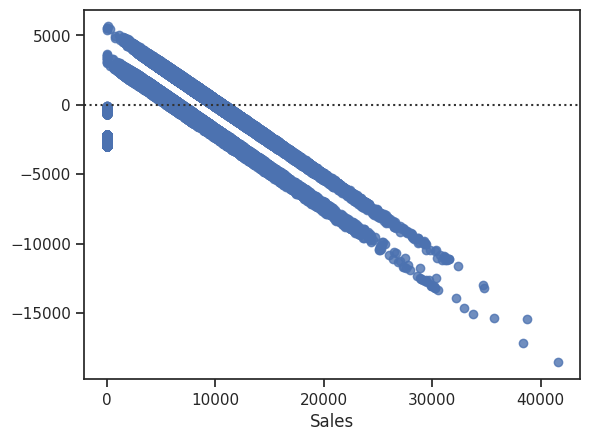

In [102]:
sns.residplot(x=y_test, y=y_pred_sklearn)

<Axes: xlabel='Sales'>

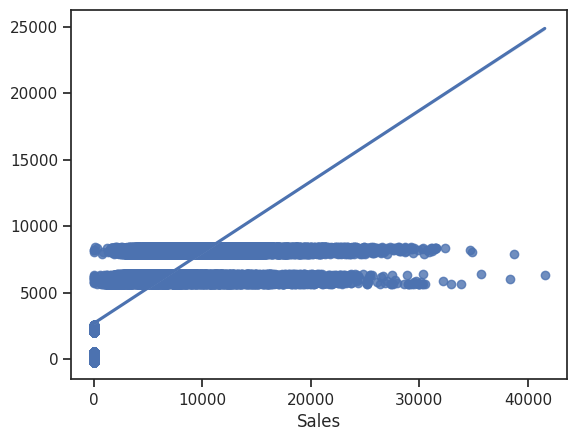

In [101]:
sns.regplot(x=y_test, y=y_pred_sklearn)


* MAE (Mean Absolute Error) => 절대값
* MSE (Mean Squared Error) => 제곱
* RMSE (Root Mean Squared Error) => 제곱 => root
* RMSLE(Root Mean Squared Logarithmic Error) => 로그를 취하고 RMSE

*** MAE(Mean Absolute Error) ***

* [Mean absolute error - Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)


$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$

In [ ]:
error = abs(y_test - y_pred)
error.describe()

### 4.3 모델 적합도 검증
- 결정 계수(R²), 잔차 분석 등

In [ ]:
# r2_score
r2_score(y_test, y_pred_sklearn)

In [97]:
# R² 계산
r2 = r2_score(train_store['Sales'], predictions)
print(f'R²: {r2}')

# MSE 계산
mse = mean_squared_error(train_store['Sales'], predictions)
print(f'MSE: {mse}')

R²: 0.1408722440110507
MSE: 8278673.075303546


In [99]:
# RMSE
np.sqrt(mse)
# RMSE
mse ** 0.5

2877.268335644687

In [103]:
# 모델 평가 - mean_squared_error
# mse_sklearn
mean_squared_error(y_test, y_pred_sklearn)

6908165.698865842

### 4.4  다중공선성 진단
- VIF 등을 통한 독립 변수 간 상호 의존성 검사

In [98]:
# VIF 계산
X = sm.add_constant(X_train)  # 상수항 추가
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         feature        VIF
0          const  25.545197
1          Promo   1.197696
2           Open   1.406982
3  SchoolHoliday   1.044952
4      DayOfWeek   1.571418
5          Store   1.000000



**회귀 계수 (Coefficients)**

1️⃣ Promo: 2,071.77
- 프로모션이 진행될 때 매출이 약 2,071.77만큼 증가하는 것을 의미합니다. 이는 프로모션이 매출에 긍정적인 영향을 미친다는 것을 나타냅니다. \

2️⃣ Open: 5,855.88 \
- 매장이 열려 있을 때 매출이 약 5,855.88만큼 증가하는 것을 의미합니다. 이는 가장 큰 긍정적 영향을 미치는 요소로 보입니다. \

3️⃣ SchoolHoliday: 68.18 \
- 학교 휴일일 경우 매출이 약 68.18만큼 증가하는 것을 의미합니다. 이는 상대적으로 작은 영향력을 가집니다.

4️⃣ DayOfWeek: -107.69 \
- 요일이 하나 증가할 때마다 매출이 약 107.69만큼 감소하는 것을 의미합니다. 주의 깊게 해석할 필요가 있는데, 요일이 숫자로 표현될 때 1이 일요일이라면, 이는 주 후반으로 갈수록 매출이 감소한다는 것을 나타낼 수 있습니다. \

5️⃣ Store: 0.061 \
- 매장 ID가 1 증가할 때마다 매출이 약 0.061만큼 증가하는 것을 의미합니다. 이는 매우 작은 영향력을 나타내며, 매장 ID 자체가 매출에 직접적인 영향을 미치는 요소는 아닐 수 있습니다.


[종합 해석]
- 이 모델은 매장의 매출을 예측하기 위한 초기 시도로 볼 수 있을 거다
- 프로모션과 매장의 오픈 여부가 매출에 가장 큰 영향을 미치는 것으로 나타났다.
- 그러나 전체적으로 모델의 설명력이 낮고, 예측 정확도에 있어서 개선의 여지가 많이 보인다. 추가적인 변수의 고려, 데이터의 전처리, 다른 모델의 시도 등을 통해 성능을 향상시킬 수 있을 것으로 기대된다.